### This notebook checks OM anisotropy in `jampy` against analytic value in the spherical case.

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import warnings

try:
    import paperfig as pf
    pf.set_fontscale(2.)
except:
    pass

In [2]:
from lenstronomy.GalKin.analytic_kinematics import AnalyticKinematics
from lenstronomy.GalKin.numeric_kinematics import NumericKinematics
from lenstronomy.Analysis.kinematics_api import KinematicsAPI
from astropy.cosmology import FlatLambdaCDM

In [3]:
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Analysis.light_profile import LightProfileAnalysis
from lenstronomy.Util.param_util import ellipticity2phi_q
import lenstronomy.Util.multi_gauss_expansion as mge
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Analysis.lens_profile import LensProfileAnalysis
from lenstronomy.Cosmo.lens_cosmo import LensCosmo

In [82]:
from mgefit.mge_fit_1d import mge_fit_1d

low_dex = -2.5
hi_dex = 2
n_gauss = 20

def get_light_mge(r_eff, mge_in_2d=True, plot=False):
    """
    :return: surf_lum in 1/pc^2 unit and sigma_lum in arcsec unit
    """
    
    light_model = LightModel(['HERNQUIST'])
    
    n = 300
    rs = np.logspace(low_dex, hi_dex, n) * 0.551*r_eff
    
    if mge_in_2d:
        light_at_r = light_model.surface_brightness(rs, rs*0, [{'amp': 1, 'Rs': 0.551*r_eff}])
    else:
        light_at_r = light_model.light_3d(rs, [{'amp': 1, 'Rs': 0.551*r_eff}])
    
#     if plot:
#         plt.loglog(rs, light_at_r)
#         plt.show()

    light_mge = mge_fit_1d(rs, light_at_r, ngauss=n_gauss, quiet=True)

    sigma_lum = light_mge.sol[1] #/ (np.sqrt(2 * np.pi) * sigma_lum)
    
    if mge_in_2d:
        surf_lum = light_mge.sol[0] / (np.sqrt(2 * np.pi) * sigma_lum)
    else:
        surf_lum = light_mge.sol[0]
    
    if plot:
        light_mge.plot()
    
    return surf_lum, sigma_lum


def get_mass_mge(theta_e, gamma, 
                 z_d=0.295, z_s=0.657, plot=False, r_eff=1.85,
                 hernquist_mass=None, angular_unit=False):
    """
    :return: surf_pot in M_pc/pc^2 unit and sigma_pot in arcsec unit
    """
    lens_cosmo = LensCosmo(z_lens=z_d, z_source=z_s)
    if hernquist_mass is None:
        lens_model = LensModel(['PEMD'])

        rs = np.logspace(low_dex, hi_dex, 300) * theta_e

        kwargs_lens = [{'theta_E': theta_e, 'gamma': gamma, 
                        'e1': 0., 'e2': 0., 'center_x': 0., 'center_y': 0.}]

        mass_at_r = lens_model.kappa(rs, rs*0, kwargs_lens)

        mass_mge = mge_fit_1d(rs, mass_at_r, ngauss=n_gauss, quiet=True)
        mass_amps, mass_sigmas = mass_mge.sol[0], mass_mge.sol[1]
        
        sigma_pot = mass_sigmas
        if angular_unit:
            surf_pot = mass_amps / (np.sqrt(2 * np.pi) * (sigma_pot))
        else:
            surf_pot = lens_cosmo.kappa2proj_mass(mass_amps / (np.sqrt(2 * np.pi) * (sigma_pot))) / 1e12 # / 206265 * D_d * 1e6))/ 2*np.pi / sigmas**2
    else:
        cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
        D_d = cosmo.angular_diameter_distance(z_d).value

        a_arcsec = 0.551 * r_eff
        a_Mpc = a_arcsec / 206265 * D_d
        a_pc = a_Mpc * 1e6
        
        n = 300  # Number of values to sample the H90 profile for the fit
        rs = np.logspace(low_dex, hi_dex, 300) * r_eff
        #r_pc = np.logspace(low_dex, hi_dex, n)* a_pc   # logarithmically spaced radii in pc
        r_pc = rs * a_pc / a_arcsec
        rho = hernquist_mass * a_pc / (2*np.pi * r_pc * (r_pc + a_pc)**3) 

        mass_mge = mge_fit_1d(r_pc, rho, ngauss=n_gauss, quiet=True)
        # plt.pause(1)

        surf_pot = mass_mge.sol[0]    # Surface density in Msun/pc**2
        sigma_pot = mass_mge.sol[1] / a_pc * a_arcsec
        
        if angular_unit:
            surf_pot = surf_pot / lens_cosmo.kappa2proj_mass(1.) * 1e12 #/ (np.sqrt(2 * np.pi) * (sigma_pot))
            
#             Rs = 0.551 * theta_e
#             Rs_Mpc = Rs / 206265 * D_d

#             lens_cosmo = LensCosmo(z_lens=z_d, z_source=z_s)

#             sigma_0 = (1e11 / (2 * np.pi * Rs_Mpc**2)) / lens_cosmo.sigma_crit 

#             kwargs_mass = [{
#                 'Rs': 0.551 * r_eff, 'sigma0': sigma_0, 'center_x': 0, 'center_y': 0
#             }]

#             lens_model = LensModel(['HERNQUIST'])

#             rs = np.logspace(low_dex, hi_dex, 300) * theta_e

#             plt.loglog(rs, lens_model.kappa(rs, rs*0, kwargs_mass))
            
        
#         approx = 0
        
#         for amp, sig in zip(mass_mge.sol[0], mass_mge.sol[1]):
#             approx += amp/(np.sqrt(2 * np.pi) * sig)**1 * np.exp(-(r/a_pc*a)**2 / 2 / sig**2)
            
#         plt.loglog(r/a_pc*a, rho)
#         plt.loglog(r/a_pc*a, approx)
#         plt.xlim(1e-3, 1e2)
#         plt.ylim(1e-8, 1e4)
#         plt.show()
        
    if plot:
        mass_mge.plot()

    return surf_pot, sigma_pot

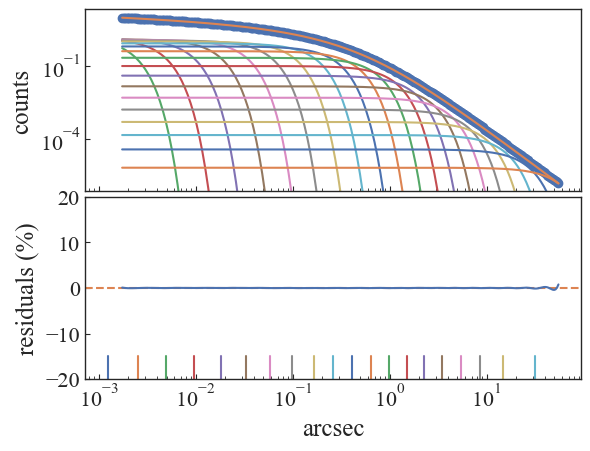

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


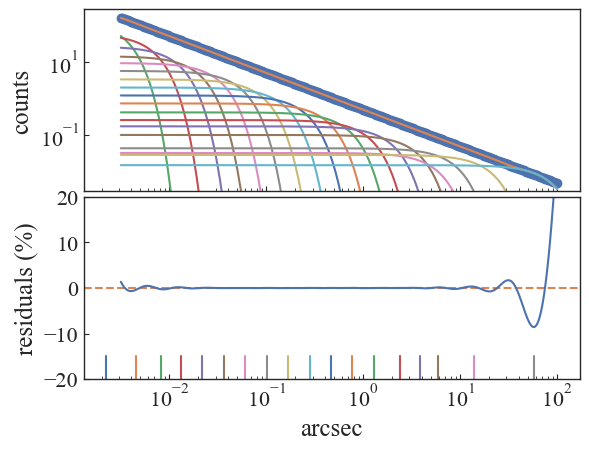

In [83]:
get_light_mge(r_eff=1, plot=True);
plt.show()
get_mass_mge(theta_e=1, gamma=2, plot=True); #, hernquist_mass=1e11);

In [84]:
r_eff = 1.85
theta_e = 1.63
gamma = 2
z_d = 0.295
z_s = 0.657
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
D_d = cosmo.angular_diameter_distance(z_d).value


def get_v_rms_analyitc(rs, theta_e, gamma, r_eff, a_ani=1,
                       z_d=0.295, z_s = 0.657
                      ):
    """
    This function doesn't work properly.
    Compute v_rms for power-law mass and Hernquist light profile using Galkin's analytical
    approach.
    """
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    D_d = cosmo.angular_diameter_distance(z_d).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(z_d, z_s).value

    kwargs_cosmo = {'d_d': D_d, 'd_s': D_s, 'd_ds': D_ds}
    analytic_kinematics = AnalyticKinematics(kwargs_cosmo)
    
    kwargs_mass = {
        'theta_E': theta_e, 'gamma': gamma
    }

    kwargs_light = {
        'a': 0.551 * r_eff, 'amp': 1.
    }

    kwargs_anisotropy = {
        'r_ani': a_ani * r_eff
    }

    sigmas = []

    for R in rs:
        IR_sigma2, IR = analytic_kinematics._I_R_sigma2(R, kwargs_mass, kwargs_light, kwargs_anisotropy)
        sigmas.append(np.sqrt(IR_sigma2/IR) / 1e3) # in km/s
        
    return np.array(sigmas)


def get_v_rms_numeric(rs, theta_e, gamma, r_eff, a_ani=1,
                      z_d=0.295, z_s = 0.657, analytic=False,
                      hernquist_mass=None, anisotropy_type='OM', 
                      do_light_mge=True, do_mass_mge=False, do_mge=False
                      ):
    """
    Compute v_rms for power-law mass and Hernquist light using Galkin's numerical
    approach.
    :param hernquist_mass: if mass in M_sun provided, uses Hernquist mass profile. For debugging purpose.
    :param do_mge: True will use lenstronomy's own MGE implementation
    """
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

    D_d = cosmo.angular_diameter_distance(z_d).value
    D_s = cosmo.angular_diameter_distance(z_s).value
    D_ds = cosmo.angular_diameter_distance_z1z2(0.5, 2.).value

    kwargs_cosmo = {'d_d': D_d, 'd_s': D_s, 'd_ds': D_ds}
    
    kwargs_aperture = {'aperture_type': 'IFU_shells',
                       'r_bins': rs,
                       }
    
    kwargs_seeing = {'psf_type': 'GAUSSIAN',
                     'fwhm': 1e-3,
                     }
    
    kwargs_galkin_numerics = {#'sampling_number': 1000,
                              'interpol_grid_num': 1000,
                              'log_integration': False,
                              'max_integrate': 100,
                              'min_integrate': 0.001,
    }
    if not analytic:
        kwargs_galkin_numerics['lum_weight_int_method'] = True if anisotropy_type=='OM' else True
    
    if hernquist_mass is None:
        kwargs_model = {
                    'lens_model_list': ['PEMD'],
                    'lens_light_model_list': ['HERNQUIST'],
                }
    else:
        kwargs_model = {
                'lens_model_list': ['HERNQUIST'],
                'lens_light_model_list': ['HERNQUIST'],
            }
        
    if do_mass_mge:
        kwargs_model['lens_model_list'] = ['MULTI_GAUSSIAN_KAPPA']
        
        
    if do_light_mge:
        kwargs_model['lens_light_model_list'] = ['MULTI_GAUSSIAN']

    
    kinematics_api = KinematicsAPI(z_lens=z_d, z_source=z_s,
                                   kwargs_model=kwargs_model,
                                   kwargs_aperture=kwargs_aperture,
                                   kwargs_seeing=kwargs_seeing,
                                   anisotropy_model=anisotropy_type,
                                   cosmo=cosmo,
                                   multi_observations=False,
                                   kwargs_numerics_galkin=kwargs_galkin_numerics,
                                   analytic_kinematics=analytic,
                                   Hernquist_approx=False,
                                   MGE_light=do_mge,
                                   MGE_mass=do_mge, #self._cgd,
                                   kwargs_mge_light=None,
                                   kwargs_mge_mass=None,
                                   sampling_number=1000,
                                   num_kin_sampling=2000,
                                   num_psf_sampling=500,
                                   )
    
    if hernquist_mass is None:
        kwargs_mass = [{
            'theta_E': theta_e, 'gamma': gamma, 'center_x': 0, 'center_y': 0, 
            'e1': 0, 'e2': 0
        }]
    else:
        Rs = 0.551 * r_eff
        Rs_Mpc = Rs / 206265 * D_d
        
        lens_cosmo = LensCosmo(z_lens=z_d, z_source=z_s)
        
        sigma_0 = (hernquist_mass / (2 * np.pi * Rs_Mpc**2)) / lens_cosmo.sigma_crit 
        
        kwargs_mass = [{
            'Rs': 0.551 * r_eff, 'sigma0': sigma_0, 'center_x': 0, 'center_y': 0
        }]
        
    if do_mass_mge:
        amp, sigma = get_mass_mge(theta_e=theta_e, gamma=gamma, 
                                  angular_unit=True, hernquist_mass=hernquist_mass)
        kwargs_mass = [{
            'amp': amp * (2 * np.pi * sigma**2),
            'sigma': sigma,
            'center_x': 0, 'center_y': 0
        }]
    
    
    if do_light_mge:
        amp, sigma = get_light_mge(r_eff=r_eff)
        kwargs_light = [{
            'amp': amp * (2 * np.pi * sigma**2),
            'sigma': sigma,
            'center_x': 0, 'center_y': 0
        }]
    else:
        kwargs_light = [{
            'Rs': 0.551 * r_eff, 'amp': 1., 'center_x': 0, 'center_y': 0
        }]
    
    if anisotropy_type == 'OM':
        kwargs_anisotropy = {
            'r_ani': a_ani * r_eff
        }
    elif anisotropy_type == 'const':
        kwargs_anisotropy = {
            'beta': a_ani
        }
        
    
    vel_dis = kinematics_api.velocity_dispersion_map(
                    kwargs_mass,
                    kwargs_light,
                    kwargs_anisotropy,
                    # r_eff=(1+np.sqrt(2))*r_eff, theta_E=theta_E,
                    # gamma=gamma,
                    kappa_ext=0,
                    direct_convolve=False,
#                     supersampling_factor=supersampling_factor,
#                     voronoi_bins=voronoi_bins,
#                     get_IR_map=True
                )
    
    return vel_dis

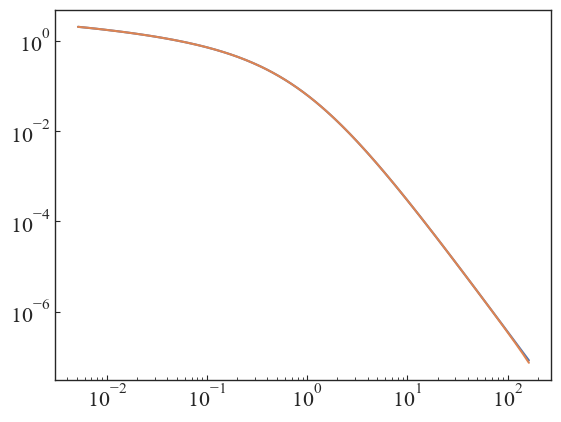

In [85]:
Rs = 0.551 * r_eff
Rs_Mpc = Rs / 206265 * D_d

lens_cosmo = LensCosmo(z_lens=z_d, z_source=z_s)

sigma_0 = (1e11 / (2 * np.pi * Rs_Mpc**2)) / lens_cosmo.sigma_crit 

kwargs_mass = [{
    'Rs': 0.551 * r_eff, 'sigma0': sigma_0, 'center_x': 0, 'center_y': 0
}]

lens_model = LensModel(['HERNQUIST'])

rs = np.logspace(low_dex, hi_dex, 300) * theta_e

plt.loglog(rs, lens_model.kappa(rs, rs*0, kwargs_mass))

amp, sigma = get_mass_mge(theta_e=theta_e, gamma=gamma, hernquist_mass=1e11, angular_unit=True)

mge_profile = 0
for a, s in zip(amp, sigma):
    mge_profile += a * np.exp(-rs**2 / 2 / s**2)
    
plt.loglog(rs, mge_profile)

## check MGE decomposition by comparing circular velocity vs analytical

Check v_circular for fidelity of `surf_pot` and `sigma_pot`

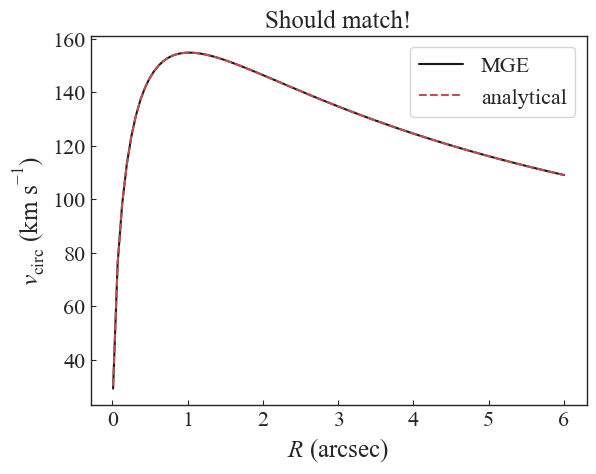

In [86]:
from jampy.jam_axi_proj import jam_axi_proj
from jampy.jam_sph_rms import jam_sph_rms
from jampy.mge_vcirc import mge_vcirc


Rs = np.linspace(0.01, 6, 100)

M_hernquist = 1e11 # M_sun
surf_pot, sigma_pot = get_mass_mge(r_eff, gamma, 
                                   hernquist_mass=M_hernquist, z_s=z_s, z_d=z_d)


v_circ_mge = mge_vcirc(surf_pot, sigma_pot, np.ones_like(sigma_pot), 
                  inc_deg=90, mbh=0, dist=D_d, rad=Rs)
plt.plot(Rs, v_circ_mge, 'k', label='MGE')

# Compare with analytic result
a_arcsec = 0.551 * r_eff
a_Mpc = a_arcsec / 206265 * D_d
a_pc = a_Mpc * 1e6
G = 0.004301

rs_pc = Rs  * a_pc / a_arcsec
v_circ_analytical = np.sqrt(G * M_hernquist * rs_pc) / (rs_pc + a_pc) # H90 equation (16)


plt.plot(Rs, v_circ_analytical, 'r--', label='analytical')
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$v_{\rm circ}$ (km s$^{-1}$)');
plt.legend()
plt.title('Should match!')
plt.show()

## Check Galkin numeric vs jampy with isotropic orbits and Hernquist mass+light profile


 NNLS quitting on iteration count.

 NNLS quitting on iteration count.
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.44
No PSF/pixel convolution: sigmapsf == 0; pixsize == 0;
inc=90.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 9.916e+11
jam_sph_rms elapsed time sec: 0.02
No PSF convolution: sigmapsf == 0; pixsize == 0;


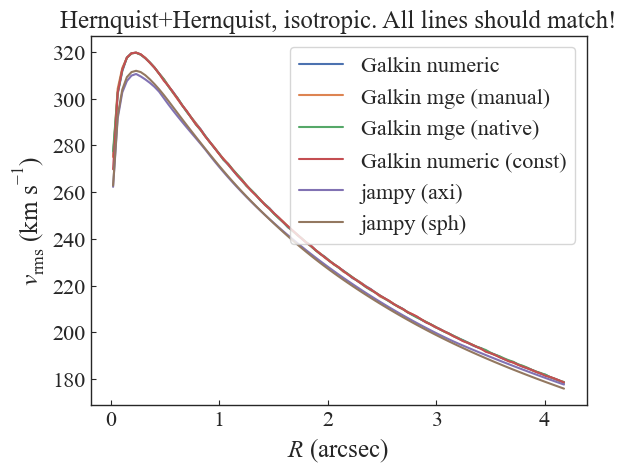

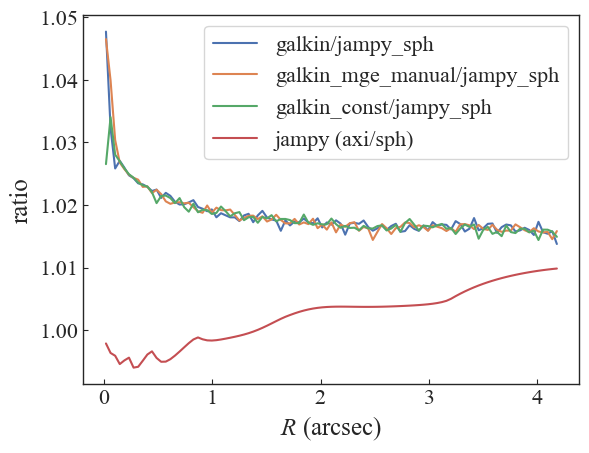

In [87]:
M_hernquist = 1e12 # M_sun

Rs_galkin = np.linspace(0, 4.2, 100)
Rs = Rs_galkin[:-1] + (Rs_galkin[1] - Rs_galkin[0])/2.

a_ani = 1e10

v_rms_numeric = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, #isotropic 
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=M_hernquist)
v_rms_numeric_mge_manual = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, #isotropic 
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=M_hernquist, 
                                  do_light_mge=True,
                                  do_mass_mge=True,
                                  #do_mge=True
                                     )

v_rms_numeric_mge_native = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, #isotropic 
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=M_hernquist, 
                                  do_light_mge=False,
                                  do_mass_mge=False,
                                  do_mge=True
                                     )

v_rms_numeric_const = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=0 if a_ani > 1e3 else 1, #isotropic 
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=M_hernquist, anisotropy_type='const')



surf_pot, sigma_pot = get_mass_mge(r_eff, gamma, z_d=z_d, z_s=z_s,
                                   hernquist_mass=M_hernquist)
beta = np.ones_like(sigma_pot) * (0 if a_ani > 1e3 else 1)

v_rms_axi = jam_axi_proj(surf_pot, sigma_pot, np.ones_like(sigma_pot), 
                         surf_pot, sigma_pot, np.ones_like(sigma_pot),
                         inc=90, mbh=0, 
                         distance=D_d, 
                         xbin=Rs, ybin=Rs*0, 
                         beta=beta, 
                         align='sph').model

v_rms_sph = jam_sph_rms(surf_pot, sigma_pot, 
                        surf_pot, sigma_pot,
                        mbh=0, 
                        distance=D_d, 
                        rad=Rs,
                        #beta=beta, 
                        scale=a_ani * r_eff,
                        #align='sph'
                       )[0]


# plt.plot(Rs, v_rms_analytic, label='analytic')
# plt.plot(Rs, v_rms_analytic, label='Galkin analytic')
plt.plot(Rs, v_rms_numeric, label='Galkin numeric')
plt.plot(Rs, v_rms_numeric_mge_manual, label='Galkin mge (manual)')
plt.plot(Rs, v_rms_numeric_mge_native, label='Galkin mge (native)')
plt.plot(Rs, v_rms_numeric_const, label='Galkin numeric (const)')

# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_sph, label='jampy (sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$v_{\rm rms}$ (km s$^{-1}$)');
plt.title('Hernquist+Hernquist, isotropic. All lines should match!')
plt.show()

#plt.plot(Rs, v_rms_analytic/v_rms_sph, label='galkin_analytic/jampy_sph')
plt.plot(Rs, v_rms_numeric/v_rms_sph, label='galkin/jampy_sph')
plt.plot(Rs, v_rms_numeric_mge_manual/v_rms_sph, label='galkin_mge_manual/jampy_sph')
plt.plot(Rs, v_rms_numeric_const/v_rms_sph, label='galkin_const/jampy_sph')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
# plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_axi/v_rms_sph, label='jampy (axi/sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'ratio');
# plt.title('All lines should match!')
plt.show()

## Check Galkin analytic vs Galkin numeric vs jampy,  power-law+Hernquist, with *isotropic orbits*

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`


/Users/ajshajib/PyCharm Projects/lenstronomy/lenstronomy/GalKin/galkin.py:120: RuntimeWarning: invalid value encountered in true_divide
  sigma_s2_average = sigma2_IR_sum / count_draws


Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 1.18
No PSF/pixel convolution: sigmapsf == 0; pixsize == 0;
inc=90.0; beta[0]=0.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.895e+13
jam_sph_rms elapsed time sec: 0.02
No PSF convolution: sigmapsf == 0; pixsize == 0;


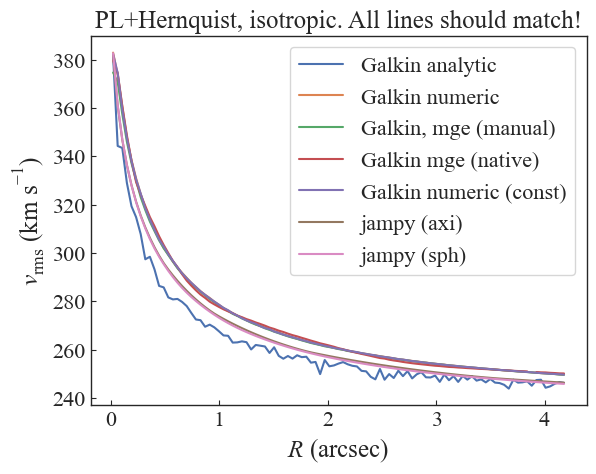

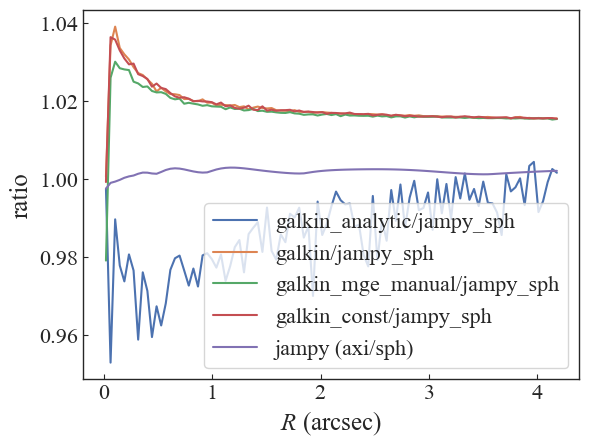

In [88]:
#v_rms_analytic = get_v_rms_analyitc(Rs, theta_e, gamma, r_eff, a_ani=1e3)

Rs_galkin = np.linspace(0, 4.2, 100)
Rs = Rs_galkin[:-1] + (Rs_galkin[1] - Rs_galkin[0])/2.

a_ani = 1e10
v_rms_analytic = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # isotropic
                                   z_d=z_d, z_s=z_s,
                                   hernquist_mass=None, analytic=True)
v_rms_numeric = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # isotropic
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=None)

v_rms_numeric_mge_manual = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # isotropic
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=None,
                                  do_light_mge=True,
                                  do_mass_mge=True
                                )

v_rms_numeric_mge = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # isotropic
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=None,
                                  do_light_mge=False,
                                  do_mass_mge=False,
                                  do_mge=True
                                )

v_rms_numeric_const = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=0., #isotropic 
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=None, anisotropy_type='const')



surf_pot, sigma_pot = get_mass_mge(theta_e, gamma, z_d=z_d, z_s=z_s,)
surf_lum, sigma_lum = get_light_mge(r_eff, mge_in_2d=True)

beta = np.ones_like(sigma_lum) * 0. # isotropic

v_rms_axi = jam_axi_proj(surf_lum, sigma_lum, np.ones_like(sigma_lum),
                         surf_pot, sigma_pot, np.ones_like(sigma_pot), 
                         inc=90, mbh=0, 
                         distance=D_d, 
                         xbin=Rs, ybin=Rs*0, 
                         beta=beta, 
                         align='sph').model

v_rms_sph = jam_sph_rms(surf_lum, sigma_lum,
                        surf_pot, sigma_pot, 
                        mbh=0, 
                        distance=D_d, 
                        rad=Rs,
                        #beta=beta, 
                        scale=a_ani*r_eff,
                        #align='sph'
                       )[0]


# plt.plot(Rs, v_rms_analytic, label='analytic')
plt.plot(Rs, v_rms_analytic, label='Galkin analytic')
plt.plot(Rs, v_rms_numeric, label='Galkin numeric')
plt.plot(Rs, v_rms_numeric_mge_manual, label='Galkin, mge (manual)')
plt.plot(Rs, v_rms_numeric_mge, label='Galkin mge (native)')
plt.plot(Rs, v_rms_numeric_const, label='Galkin numeric (const)')

# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_sph, label='jampy (sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$v_{\rm rms}$ (km s$^{-1}$)');
plt.title('PL+Hernquist, isotropic. All lines should match!')
plt.show()

plt.plot(Rs, v_rms_analytic/v_rms_sph, label='galkin_analytic/jampy_sph')
plt.plot(Rs, v_rms_numeric/v_rms_sph, label='galkin/jampy_sph')
plt.plot(Rs, v_rms_numeric_mge_manual/v_rms_sph, label='galkin_mge_manual/jampy_sph')
plt.plot(Rs, v_rms_numeric_const/v_rms_sph, label='galkin_const/jampy_sph')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
# plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_axi/v_rms_sph, label='jampy (axi/sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'ratio');
# plt.title('All lines should match!')
plt.show()



## Check Galkin analytic vs Galkin numeric vs jampy with power-law+Hernquist light, and *radial orbits*

Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
jam_axi_proj_sph_zz (analytic_los=False) elapsed time sec: 26.21
No PSF/pixel convolution: sigmapsf == 0; pixsize == 0;
inc=90.0; beta[0]=1.0; kappa=1.00; M/L=1.00; BH=0.0; chi2/DOF=nan
Total mass MGE (MSun): 6.895e+13
jam_sph_rms elapsed time sec: 0.03
No PSF convolution: sigmapsf == 0; pixsize == 0;


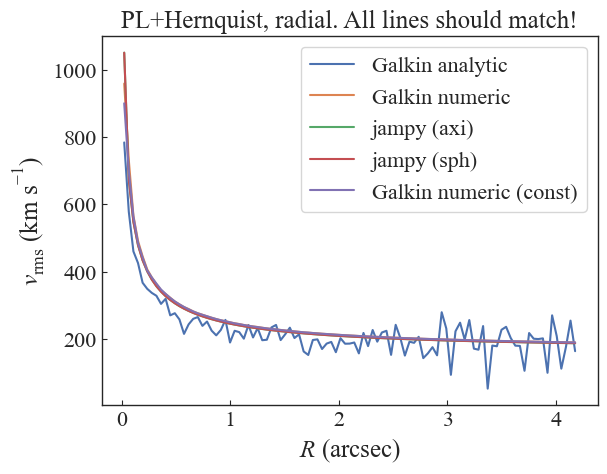

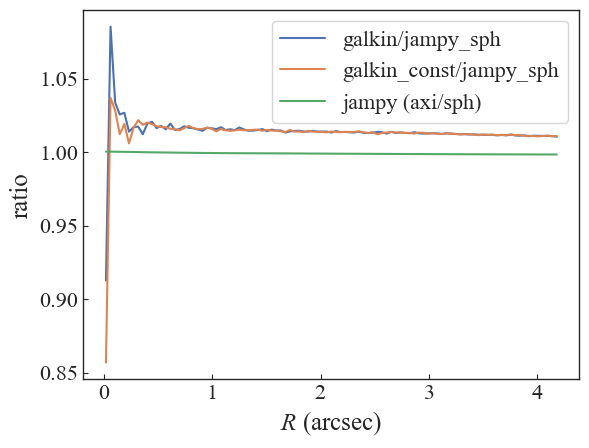

In [12]:
#v_rms_analytic = get_v_rms_analyitc(Rs, theta_e, gamma, r_eff, a_ani=1e3)

# Rs = np.linspace(0.01, 4.2, 100)
# Rs_galkin = np.zeros(len(Rs)+1)
# Rs_galkin[:-1] = Rs - (Rs[1] - Rs[0])/2.
# Rs_galkin[-1] = Rs[-1] + (Rs[1] - Rs[0])/2.

Rs_galkin = np.linspace(0, 4.2, 100)
Rs = Rs_galkin[:-1] + (Rs_galkin[1] - Rs_galkin[0])/2.

a_ani = 1e-10
v_rms_analytic = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # radial
                                  hernquist_mass=None, analytic=True)
v_rms_numeric = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=a_ani, # radial
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=None)
v_rms_numeric_const = get_v_rms_numeric(Rs_galkin, theta_e, gamma, r_eff, a_ani=1., # radial
                                  z_d=z_d, z_s=z_s,
                                  hernquist_mass=None, anisotropy_type='const')



surf_pot, sigma_pot = get_mass_mge(theta_e, gamma)
surf_lum, sigma_lum = get_light_mge(r_eff, mge_in_2d=True)

beta = np.ones_like(sigma_lum) #(sigma_lum)**2 / ((a_ani * r_eff)**2 + sigma_lum**2) #np.ones_like(sigma_lum) * 0.

v_rms_axi = jam_axi_proj(surf_lum, sigma_lum, np.ones_like(sigma_lum),
                         surf_pot, sigma_pot, np.ones_like(sigma_pot), 
                         inc=90, mbh=0, 
                         distance=D_d, 
                         xbin=Rs, ybin=Rs*0, 
                         beta=beta, nrad=100, nlos=1500, nang=100,
                         align='sph').model

v_rms_sph = jam_sph_rms(surf_lum, sigma_lum,
                        surf_pot, sigma_pot, 
                        mbh=0, 
                        distance=D_d, 
                        rad=Rs,
                        beta=beta, 
                        #align='sph'
                       )[0]


# plt.plot(Rs, v_rms_analytic, label='analytic')
plt.plot(Rs, v_rms_analytic, label='Galkin analytic')
plt.plot(Rs, v_rms_numeric, label='Galkin numeric')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_sph, label='jampy (sph)')
plt.plot(Rs, v_rms_numeric_const, label='Galkin numeric (const)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'$v_{\rm rms}$ (km s$^{-1}$)');
plt.title('PL+Hernquist, radial. All lines should match!')
plt.show()


plt.plot(Rs, v_rms_numeric/v_rms_sph, label='galkin/jampy_sph')
plt.plot(Rs, v_rms_numeric_const/v_rms_sph, label='galkin_const/jampy_sph')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_2, label='MGE')
# plt.plot(Rs[:-1]+(Rs[1] - Rs[0])/2, v_rms_numeric_3, label='analytic')
# plt.plot(Rs, v_rms_axi, label='jampy (axi)')
plt.plot(Rs, v_rms_axi/v_rms_sph, label='jampy (axi/sph)')

plt.legend()
plt.xlabel(r'$R$ (arcsec)')
plt.ylabel(r'ratio');
# plt.title('All lines should match!')
plt.show()

## check effective anisotropy profile in `jampy`

jam_axi_intr_sph elapsed time (sec): 1.44
jam_axi_intr_sph elapsed time (sec): 1.36
jam_axi_intr_sph elapsed time (sec): 1.33
jam_axi_intr_sph elapsed time (sec): 1.32
jam_axi_intr_sph elapsed time (sec): 1.30
jam_axi_intr_sph elapsed time (sec): 1.27


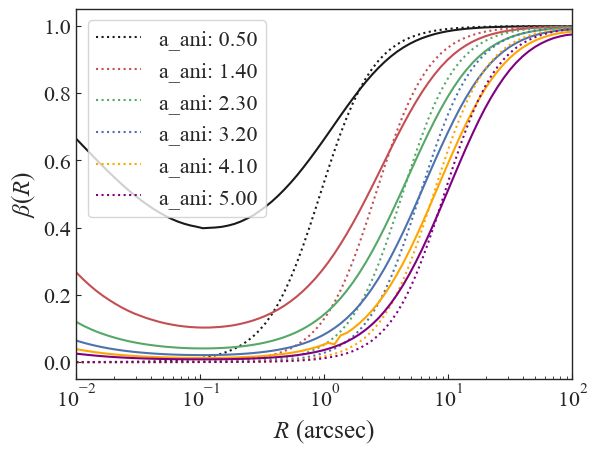

In [11]:
from jampy.jam_axi_intr import jam_axi_intr

rs = np.logspace(-3, 2, 100)

for i, a_ani in enumerate(np.linspace(0.5, 5, 6)):
    beta = (sigma_lum)**2 / ((a_ani * r_eff)**2 + sigma_lum**2) #np.ones_like(sigma_lum) * 0.
    
    beta[0] = -0.05
    beta[1] = -0.05
    
    jam_moments = jam_axi_intr(
                        surf_lum/(2*np.pi*sigma_lum**2)**0.5, sigma_lum, np.ones_like(sigma_lum),
                        surf_pot/(2*np.pi*sigma_pot**2)**0.5, sigma_pot, np.ones_like(sigma_pot), 
                        mbh=0,
                        Rbin=rs, zbin=rs*0, 
                        plot=False, # pixsize=0.,
                        # self.PIXEL_SIZE/supersampling_factor,
                        # pixang=0., quiet=1,
                        # sigmapsf=0., normpsf=norm_psf,
                        #moment=moment,
                        # goodbins=goodbins,
                        align='sph',
                        beta=beta,
                        proj_cyl=False,
                        # data=rms, errors=erms,
                        ml=1).model


    parametric_beta = rs**2 / ((a_ani * r_eff)**2 + rs**2)
    
    colors = ['k', 'r', 'g', 'b', 'orange', 'purple']
    plt.plot(rs, parametric_beta, ':', c=colors[i], label='a_ani: {:.2f}'.format(a_ani)) # label='parametric')
    plt.plot(rs, 1 - jam_moments[1] / jam_moments[0], '-', c=colors[i]) #,  label='computed')
    plt.legend()
    plt.xscale('log')
    plt.xlim(1e-2, 1e2)
    plt.xlabel(r'$R$ (arcsec)')
    plt.ylabel(r'$\beta(R)$')
    #plt.title('a_ani: {:.2f}'.format(a_ani))
    #plt.show()